In [1]:
from glob import glob
import os

def binary_process_masks(in_folder, out_folder):
  if not os.path.exists(out_folder):
    os.makedirs(out_folder)
  for mask_path in glob(in_folder+'*.jpg'):
    plt.imsave(out_folder+mask_path.split('/')[-1], np.array(Image.open(mask_path)) == 2, cmap='gray')

'''
Make Binary segmentation class. Target: gross Ciona things.
binary_process_masks('./data/ciona/train/masks/', './data/ciona/train/binary_masks/')
binary_process_masks('./data/ciona/validation/masks/', './data/ciona/validation/binary_masks/')
'''

import numpy as np
import random
import torch

def set_seed(seed):
  '''Make experiments things more deterministic'''
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  
  
from glob import glob

def merge_ciona(is_test):
  if is_test:
    files = glob('./data/ciona/validation/images/*.jpg') 
  else:
    files = glob('./data/ciona/train/images/*.jpg')
    
  samples = []
  for file in files:
    slash_split = file.split('/')
    mask = '/'.join(slash_split[:-2])+'/binary_masks/'+slash_split[-1][:-4]+'_mask.jpg'
    samples.append((file, mask))
  return samples


from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F_img
from PIL import Image

class BinaryMaskDataset(Dataset):
  def __init__(self, img_mask_pairs, img_size, img_mean=[.5, .5, .5], img_std=[.5, .5, .5]):
    
    self.img_mask_pairs = img_mask_pairs
    self.img_mean, self.img_std = img_mean, img_std
    self.img_size = img_size

    
  def __len__(self):
    return len(self.img_mask_pairs)
  
  def __getitem__(self, idx):
    img = Image.open(self.img_mask_pairs[idx][0]) 
    img_mask = F_img.to_grayscale(Image.open(self.img_mask_pairs[idx][1]))
    
    if random.random() > .5:
      img = F_img.hflip(img)
      img_mask = F_img.hflip(img_mask)
    if random.random() > .5:
      img = F_img.vflip(img)
      img_mask = F_img.vflip(img_mask)
      
    rotation = random.uniform(-20, 20)
    img = F_img.rotate(img, rotation)
    img_mask = F_img.rotate(img_mask, rotation)
    
    img = F_img.resize(img, [self.img_size, self.img_size])
    img_mask = F_img.resize(img_mask, [self.img_size, self.img_size])
    
    return F_img.normalize(F_img.to_tensor(img), self.img_mean, self.img_std), F_img.to_tensor(img_mask)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import random
from random import randint, uniform
from pyfastnoisesimd import generate

def Conv(in_c, out_c):
  return nn.Sequential(
    nn.Conv2d(in_c, out_c, 3, padding=1),
    nn.ELU(True),
    nn.BatchNorm2d(out_c),
    nn.Conv2d(out_c, out_c, 3, padding=1),
    nn.ELU(True),
    nn.BatchNorm2d(out_c),
  )
    
class UNet128(nn.Module):
  def __init__(self):
    super(UNet128, self).__init__()# (  3, 128, 128)
    self.down0 = Conv(  3,   8) #--> (  8, 128, 128) 
    self.down1 = Conv(  8,  16) #--> ( 16,  64,  64)
    self.down2 = Conv( 16,  32) #--> ( 32,  32,  32)
    self.down3 = Conv( 32,  64) #--> ( 64,  16,  16)
    self.down4 = Conv( 64, 128) #--> (128,   8,   8)
    self.up0   = Conv(192,  64) #--> ( 64,  16,  16)
    self.up1   = Conv( 96,  32) #--> ( 32,  32,  32)
    self.up2   = Conv( 48,  16) #--> ( 16,  64,  64)
    self.up3   = Conv( 24,   8) #--> (  8, 128, 128)
    self.tail  = nn.Conv2d(8, 1, 1)
    self.downpool = nn.MaxPool2d(2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
    
  def forward(self, x_inbatch):
    x_008_128 = self.down0(x_inbatch)
    x_016_064 = self.down1(self.downpool(x_008_128))
    x_032_032 = self.down2(self.downpool(x_016_064))
    x_064_016 = self.down3(self.downpool(x_032_032))
    x_128_008 = self.down4(self.downpool(x_064_016))
    x_upbatch = self.up0(torch.cat([self.upsample(x_128_008), x_064_016], dim=1))
    x_upbatch = self.up1(torch.cat([self.upsample(x_upbatch), x_032_032], dim=1))
    x_upbatch = self.up2(torch.cat([self.upsample(x_upbatch), x_016_064], dim=1))
    x_upbatch = self.up3(torch.cat([self.upsample(x_upbatch), x_008_128], dim=1))
    return self.tail(x_upbatch)

def eval_model(model):
  metric = 0
  samples_seen = 0
  model.network.eval()
  with torch.no_grad():
    for img, mask in model.loader_test:
      model.img_cuda.copy_(img)
      del img
      model.mask_cuda.copy_(mask)
      del mask
      loss = F.binary_cross_entropy_with_logits(model.network(model.img_cuda), model.mask_cuda) * 10
      metric += loss.item()
      samples_seen += model.batch_size
  model.test_log['epoch'].append(model.epochs_trained)
  model.test_log['metric'].append(metric / samples_seen)
  
  
def train(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.network.train()
    for img, mask in model.loader:
      model.img_cuda.copy_(img)
      del img
      model.mask_cuda.copy_(mask)
      del mask
      model.optimizer.zero_grad()
      loss = F.binary_cross_entropy_with_logits(model.network(model.img_cuda), model.mask_cuda) * 10
      metric += loss.item()
      samples_seen += model.batch_size
      loss.backward()
      model.optimizer.step()
      model.scheduler.step()
    model.train_log['epoch'].append(model.epochs_trained)
    model.train_log['metric'].append(metric / samples_seen)
    
    eval_model(model)
    
    model.epochs_trained += 1

def interpolate(a, b, f):
  return (a * (1.0 - f)) + (b * f)
    
def train_mixup(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.network.train()
    for (img_a, mask_a), (img_b, mask_b) in zip(model.loader, model.loader_other):
      mixup_lerp = random.random()
      model.img_cuda.copy_(interpolate(img_a, img_b, mixup_lerp))
      del img_a; del img_b
      model.mask_cuda.copy_(interpolate(mask_a, mask_b, mixup_lerp))
      del mask_a; del mask_b
      model.optimizer.zero_grad()
      loss = F.binary_cross_entropy_with_logits(model.network(model.img_cuda), model.mask_cuda) * 10
      metric += loss.item()
      samples_seen += model.batch_size
      loss.backward()
      model.optimizer.step()
      model.scheduler.step()
    model.train_log['epoch'].append(model.epochs_trained)
    model.train_log['metric'].append(metric / samples_seen)
    
    eval_model(model)
    
    model.epochs_trained += 1


def generate_noise():
  if random.random() > .5:
    return generate(size=[1, 128, 128], noiseType='Perlin', perturbType='Gradient',
                    freq=uniform(.001, .06), seed=randint(0, 100000))[0]
  else:
    return generate(size=[1, 128, 128], noiseType='Perlin',
                    freq=uniform(.001, .06), seed=randint(0, 100000))[0]
    
def train_noisy_mixup(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.network.train()
    for (img_a, mask_a), (img_b, mask_b) in zip(model.loader, model.loader_other):
      mixup_lerp = (torch.tensor(generate_noise()) + 1) / 2
      model.img_cuda.copy_(interpolate(img_a, img_b, mixup_lerp))
      del img_a; del img_b
      model.mask_cuda.copy_(interpolate(mask_a, mask_b, mixup_lerp))
      del mask_a; del mask_b
      model.optimizer.zero_grad()
      loss = F.binary_cross_entropy_with_logits(model.network(model.img_cuda), model.mask_cuda) * 10
      metric += loss.item()
      samples_seen += model.batch_size
      loss.backward()
      model.optimizer.step()
      model.scheduler.step()
    model.train_log['epoch'].append(model.epochs_trained)
    model.train_log['metric'].append(metric / samples_seen)
    
    eval_model(model)
    
    model.epochs_trained += 1

In [3]:
class UNetLatentMixup128(nn.Module):
  def __init__(self):
    super(UNetLatentMixup128, self).__init__()
    self.down0 = Conv(  3,   8)      #--> (  8, 128, 128) 
    self.down1 = Conv(  8,  16)      #--> ( 16,  64,  64)
    self.down2 = Conv( 16,  32)      #--> ( 32,  32,  32)
    self.down3 = Conv( 32,  64)      #--> ( 64,  16,  16)
    self.down4 = Conv( 64, 128)      #--> (128,   8,   8)
    self.up0   = Conv(192,  64)      #--> ( 64,  16,  16)
    self.up1   = Conv( 96,  32)      #--> ( 32,  32,  32)
    self.up2   = Conv( 48,  16)      #--> ( 16,  64,  64)
    self.up3   = Conv( 24,   8)      #--> (  8, 128, 128)
    self.downpool = nn.MaxPool2d(2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
    
    self.ops = [self._op('x_008_128', lambda features: self.down0(features['x_inbatch'])),
                self._op('x_016_064', lambda features: self.down1(self.downpool(features['x_008_128']))),
                self._op('x_032_032', lambda features: self.down2(self.downpool(features['x_016_064']))),
                self._op('x_064_016', lambda features: self.down3(self.downpool(features['x_032_032']))),
                self._op('x_128_008', lambda features: self.down4(self.downpool(features['x_064_016']))),
                self._op('x_upbatch', lambda features: self.up0(torch.cat([self.upsample(features['x_128_008']), features['x_064_016']], dim=1))), 
                self._op('x_upbatch', lambda features: self.up1(torch.cat([self.upsample(features['x_upbatch']), features['x_032_032']], dim=1))),
                self._op('x_upbatch', lambda features: self.up2(torch.cat([self.upsample(features['x_upbatch']), features['x_016_064']], dim=1))),
                self._op('x_upbatch', lambda features: self.up3(torch.cat([self.upsample(features['x_upbatch']), features['x_008_128']], dim=1)))]
    self.ops_len = len(self.ops)
    self.tail  = nn.Conv2d(8, 1, 1)
    

  def _op(self, key, op):
    def operation(features):
      features[key] = op(features)
    return operation
    
  def forward(self, batch_a, batch_b=None, mixup_ind=None, mixup_lerp=None):
    features_a = {'x_inbatch':batch_a}
    if batch_b is not None:
      features_b = {'x_inbatch':batch_b}
      for op in self.ops[:mixup_ind-1]:
        op(features_a); op(features_b)
      features = {key:interpolate(features_a[key], features_b[key], mixup_lerp) for key in features_a.keys()}
      for op in self.ops[mixup_ind-1:]:
        op(features)
      return self.tail(features['x_upbatch'])
    else:
      for op in self.ops:
        op(features_a)
      return self.tail(features_a['x_upbatch'])
    
def train_postponed_mixup(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.network.train()
    for (img_a, mask_a), (img_b, mask_b) in zip(model.loader, model.loader_other):
      mixup_ind = max(int(np.random.beta(1, 2) * (model.network.ops_len + 1)), 0)
      mixup_lerp = random.random()
      if mixup_ind == 0:
        model.img_cuda.copy_(interpolate(img_a, img_b, mixup_lerp))
        del img_a; del img_b
        model.mask_cuda.copy_(interpolate(mask_a, mask_b, mixup_lerp))
        del mask_a; del mask_b
        model.optimizer.zero_grad()
        loss = F.binary_cross_entropy_with_logits(model.network(model.img_cuda), model.mask_cuda) * 10
      else:
        print(bad)
        model.img_cuda.copy_(img_a)
        del img_a
        model.img_cuda_other.copy_(img_b)
        del img_b
        model.mask_cuda.copy_(interpolate(mask_a, mask_b, mixup_lerp))
        del mask_a; del mask_b
        model.optimizer.zero_grad()
        loss = F.binary_cross_entropy_with_logits(model.network(model.img_cuda, model.img_cuda_other, mixup_ind, mixup_lerp), model.mask_cuda) * 10
      metric += loss.item()
      samples_seen += model.batch_size
      loss.backward()
      model.optimizer.step()
      model.scheduler.step()
    model.train_log['epoch'].append(model.epochs_trained)
    model.train_log['metric'].append(metric / samples_seen)
    
    eval_model(model)
    
    model.epochs_trained += 1

In [4]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR as CosineLR
from dotted.collection import DottedDict

img_mean, img_std = [0.31124189, 0.32396105, 0.34730537], [0.18927718, 0.20498018, 0.23484531]
train_dataset = BinaryMaskDataset(merge_ciona(is_test=False), 128, img_mean, img_std)
test_dataset = BinaryMaskDataset(merge_ciona(is_test=True), 128, img_mean, img_std)

model = DottedDict()

model['seed'] = 300
set_seed(model.seed)

# experiment tracking
model['epochs_trained'] = 0
model['train_log'] = {'label':'Stochastically Postponed Mixup Train Loss', 'epoch':[], 'metric':[]}
model['test_log'] = {'label':'Stochastically Postponed Mixup Test Loss', 'epoch':[], 'metric':[]}

# model and optimization
model['network'] = UNetLatentMixup128().cuda()#UNet128().cuda()
model['batch_size'] = 48
model['optimizer'] = optim.Adam(model.network.parameters(), lr=0.001)
model['scheduler'] = CosineLR(model.optimizer, len(train_dataset) * 1000 / model.batch_size, .00005)

# data
model['loader'] = DataLoader(train_dataset, model.batch_size, True, num_workers=3, drop_last=True, pin_memory=True)
model['loader_other'] = DataLoader(train_dataset, model.batch_size, True, num_workers=3, drop_last=True, pin_memory=True)
model['loader_test'] = DataLoader(test_dataset, model.batch_size, True, num_workers=3, drop_last=True, pin_memory=True)
model['img_cuda'] = torch.empty([model.batch_size, 3, 128, 128]).cuda()
model['img_cuda_other'] = torch.empty([model.batch_size, 3, 128, 128]).cuda()
model['mask_cuda'] = torch.empty([model.batch_size, 1, 128, 128]).cuda()

In [ ]:
train_mixup(model, 500)

epochs:  69%|██████▊   | 343/500 [36:20<16:38,  6.36s/it]

In [ ]:
torch.save(model.to_python(), f'./models/seed{model.seed}_mixup_epoch{model.epochs_trained}.model')

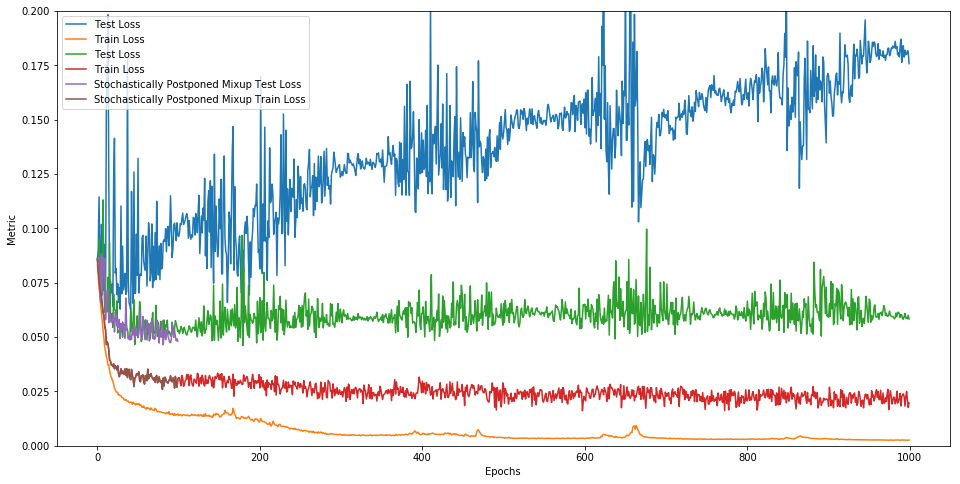

In [8]:
import torch
model_standard = torch.load('./models/seed1000_standard_aug_epoch1000.model', map_location='cpu')
model_mixup = torch.load('./models/seed1000_mixup_epoch1000.model', map_location='cpu')
#model_noisy_mixup = torch.load('./models/seed1000_noisy_mixup_epoch1000.model', map_location='cpu')

import matplotlib.pyplot as plt

def plot_metrics(metric_logs, ylim=None):
  plt.figure(figsize=(16, 8))
  for metric_log in metric_logs:
    plt.plot(metric_log['epoch'], metric_log['metric'], label=metric_log['label'])
  plt.xlabel('Epochs')
  plt.ylabel('Metric')
  if ylim is not None: plt.ylim(*ylim)
  plt.legend()
  plt.show()
  
plot_metrics([model_standard['test_log'], model_standard['train_log'], 
              model_mixup['test_log'], model_mixup['train_log'],
              model.test_log, model.train_log], ylim=(0, .2))

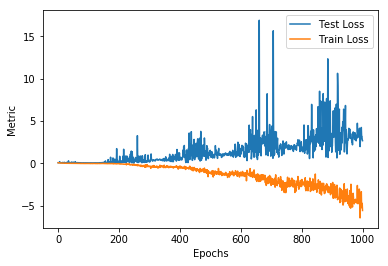

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(metric_logs, ylim=None):
  for metric_log in metric_logs:
    plt.plot(metric_log['epoch'], metric_log['metric'], label=metric_log['label'])
  plt.xlabel('Epochs')
  plt.ylabel('Metric')
  if ylim is not None: plt.ylim(*ylim)
  plt.legend()
  plt.show()
  
plot_metrics([model.test_log, model.train_log])